In [2]:
from multiprocessing import Pool
from d2c.data_generation.builder import TSBuilder

n_variables = 5
process = 1
noise_std = 0.001
max_neighborhood_size = 2
maxlags = 3

tsbuilder = TSBuilder(observations_per_time_series=25, 
                        maxlags=maxlags, 
                        n_variables=n_variables, 
                        time_series_per_process=1, 
                        processes_to_use=[process], 
                        noise_std=noise_std, 
                        max_neighborhood_size=max_neighborhood_size, 
                        seed=42, 
                        max_attempts=20,
                        verbose=True)

tsbuilder.build()

In [3]:
import pandas as pd 
pd.DataFrame(tsbuilder.get_generated_observations()[1][0])

,0,1,2,3,4
0,0.712569,0.601736,1.220099,0.689470,0.387217
1,0.856346,1.042727,1.526494,1.115895,0.909992
2,1.380457,1.354174,1.161862,1.480075,1.408838
3,1.515645,1.519205,0.264640,1.348142,1.488786
4,0.628601,0.813913,0.269340,0.473941,0.589428
5,-0.078369,-0.086761,0.710499,0.037373,-0.066524
6,0.599358,0.600255,1.137044,0.600913,0.600516
7,0.980150,0.943964,1.492956,1.002143,0.981254
8,1.391383,1.367835,1.317824,1.401253,1.390770
9,1.491738,1.513444,0.429535,1.481684,1.491657


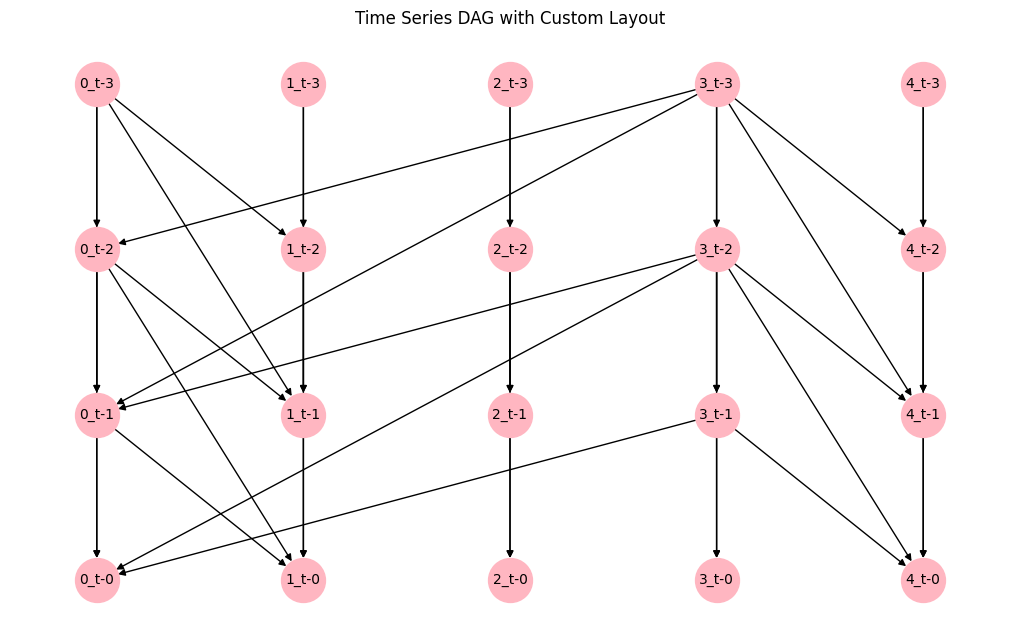

In [4]:
from d2c.data_generation.utils import show_DAG
dag = tsbuilder.get_generated_dags()[1][0]
show_DAG(dag,n_variables,maxlags)

In [5]:
from d2c.descriptors import D2C, DataLoader

dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
dataloader.from_tsbuilder(tsbuilder)

d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=50, 
            MB_size=3, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=42,
            n_jobs=50,
            full=False)

d2c.initialize()

In [6]:
descriptors_df = d2c.get_descriptors_df()
descriptors_df.head(6).round(2)

,graph_id,edge_source,edge_dest,is_causal,coeff_cause,coeff_eff,m_cau_q6,mca_mef_cau_q4,mca_mef_eff_q4,HOC_3_1,kurtosis_ca,kurtosis_ef
0,0,10,1,1,0.03,0.00,0.21,1.0,0.0,-0.78,-0.69,-0.94
1,0,1,10,0,0.00,0.03,0.18,0.0,1.0,-1.07,-0.94,-0.69
2,0,10,5,1,-0.00,0.00,0.15,1.0,1.0,0.61,-0.69,-1.01
3,0,5,10,0,0.00,-0.00,0.20,1.0,1.0,0.65,-1.01,-0.69
4,0,19,9,1,0.00,-0.03,0.30,1.0,1.0,-0.80,-0.93,-1.03
5,0,9,19,0,-0.03,0.00,0.26,1.0,1.0,-1.10,-1.03,-0.93


In [ ]:
descriptors_df

In [53]:
descriptors_df.columns[4:]

Index(['coeff_cause', 'coeff_eff', 'm_cau_q6', 'mca_mef_cau_q4',
       'mca_mef_eff_q4', 'HOC_3_1', 'kurtosis_ca', 'kurtosis_ef'],
      dtype='object')

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Perform a 50% train-test split on the descriptors dataframe
train_df, test_df = train_test_split(descriptors_df, test_size=0.5, random_state=42)

# Separate the features (X) and the target variable (y)
X_train = train_df[descriptors_df.columns[4:]]
y_train = train_df['is_causal']
X_test = test_df[descriptors_df.columns[4:]]
y_test = test_df['is_causal']

# Initialize the decision tree classifier
clf = RandomForestClassifier()

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict_proba(X_test)[:,1]

# Measure the accuracy of the classifier
accuracy = roc_auc_score(y_test, y_pred)
accuracy


0.5168067226890757